In [16]:
import pandas as pd
from copy import deepcopy
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

In [2]:
df_first = pd.read_csv("Task1_1.csv", sep=';', engine='python')
df_first.drop_duplicates(subset=None, inplace=True)

df_second = pd.read_csv("Task1_2.csv", sep=';', engine='python')
df_second.drop_duplicates(subset=None, inplace=True)

merged_df = pd.merge(df_first, df_second, on='ID', how='outer')

<Axes: xlabel='Type', ylabel='count'>

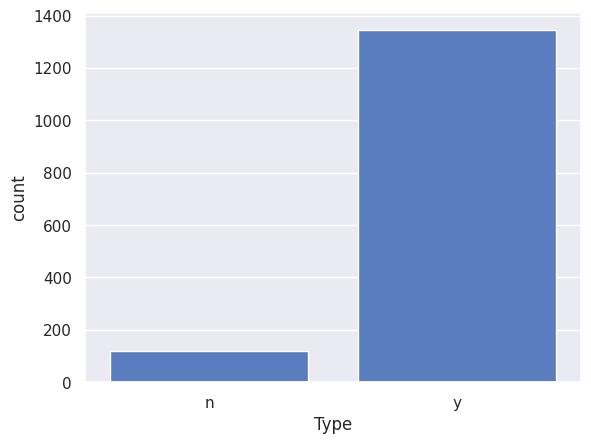

In [3]:
merged_df = merged_df.dropna()
sns.set(style="darkgrid", palette="muted")
sns.countplot(x='Type', data=merged_df)

In [4]:
encoder = LabelEncoder()
string_cols = merged_df.select_dtypes(include='object').columns # it will be required to encode string values
for col in string_cols:
    merged_df.loc[:, col] = encoder.fit_transform(merged_df[col])

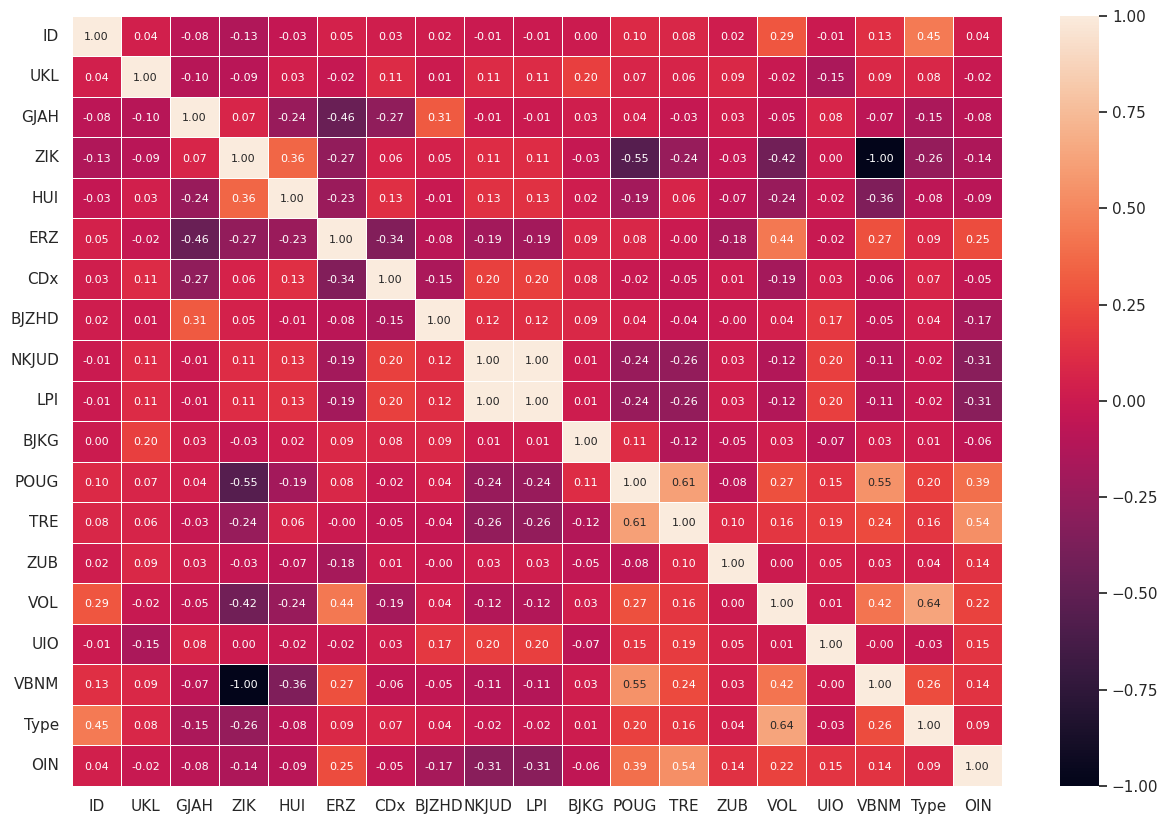

In [5]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(merged_df.corr(), ax=ax, annot=True, fmt=".2f", linewidths=.5)

# adjust the size of annotations
for text in ax.texts:
    text.set_fontsize(8)

# adjust the position of annotations
for text in ax.texts:
    x, y = text.get_position()
    text.set_position((x, y+0.02))

plt.show()


### Maybe we can drop either ZIK or VBNM since they have -1 correlation and likewise LPI and NKJUD, but since the data is not that large, no harm can be done

In [6]:
y = merged_df.Type
X = merged_df.drop("Type", axis=1) 

### Let's normalize the data, since we'll use normalization later, it aviods uncessary biases

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### 40%-60% test-train split is selected

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) # Spliting Train Test datasets
y_test = y_test.astype(int)
y_train = y_train.astype(int)

### Create 10 splits for different parameters

In [9]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

### Since the database is small and from correlation heatmap not so complex, I've decided to go with logistic regression, since it is the heart of classification

In [10]:
params = {
    'penalty': ['l1','l2'],
    'C': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]
}

logreg = LogisticRegression(solver='liblinear')
grid = GridSearchCV(logreg, param_grid=params, scoring='accuracy', n_jobs =-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3,
                               4, 5, 6, 7, 8, 9, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

### Let's look at validation scores to see how well did the training go

In [11]:
logreg_grid_val_score = grid.best_score_
print('Best Score:', logreg_grid_val_score)
print('Best Params:', grid.best_params_)
print('Best Estimator:', grid.best_estimator_)

Best Score: 0.9746212121212121
Best Params: {'C': 0.3, 'penalty': 'l1'}
Best Estimator: LogisticRegression(C=0.3, penalty='l1', solver='liblinear')


### Then continuing with best estimatior from cross validation, we can make the predictions on the test data

In [12]:
logreg_grid = grid.best_estimator_
y_pred = logreg_grid.predict(X_test)

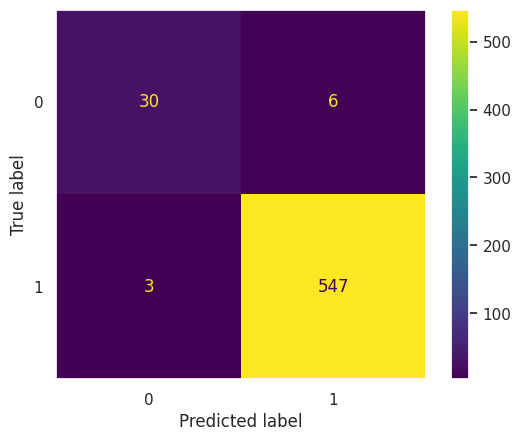

In [13]:
cm = ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test, y_test)
ax = cm.ax_
ax.grid(False)
plt.show()

### From the confusion matrix, we can see that results are pretty well, and classifier works almost perfect

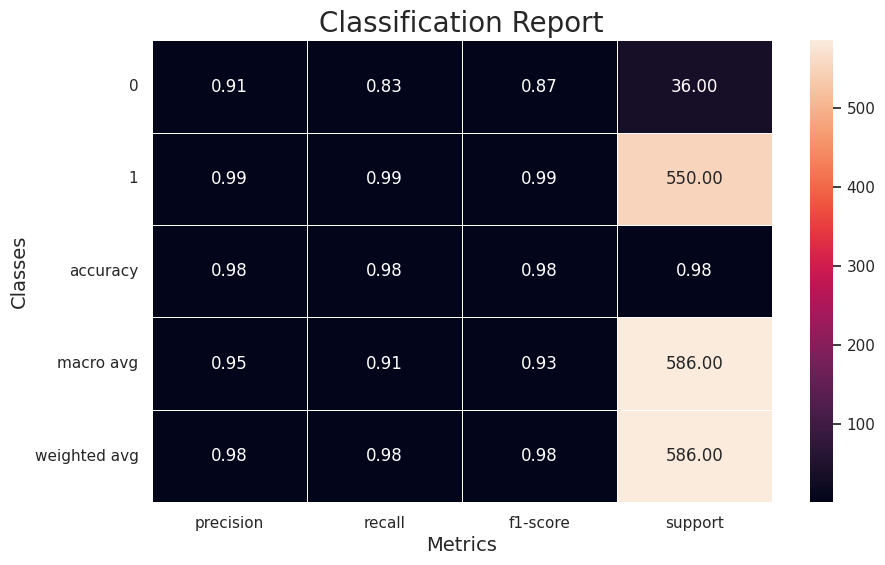

In [18]:
report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_report, annot=True, fmt=".2f", linewidths=.5, ax=ax)

ax.set_title('Classification Report', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax.set_xlabel('Metrics', fontdict={'fontsize': 14, 'fontweight': 'medium'})
ax.set_ylabel('Classes', fontdict={'fontsize': 14, 'fontweight': 'medium'})

plt.show()

### macro avg --> treats all classes equally, since we have some data inbalance it is also a good measure to look at
### if we just want to take frequency of the classes into consideration then weighted avg might be a better option